**Plant Disease Detection using CNN**

---


**Mount Google Drive in Colab**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Importing Libraries for PyTorch Data Handling and Image Processing**

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
import os
import zipfile

**Downloading and Verifying the Plant Disease Dataset Using KaggleHub**

In [ ]:
import kagglehub

# Download latest version
dataset_path = kagglehub.dataset_download("emmarex/plantdisease")

if not os.path.exists(dataset_path):
    print("Dataset not found! Please upload it to Google Drive or Colab.")
else:
    print("Path to dataset files:", dataset_path)

100%|██████████| 658M/658M [00:02<00:00, 235MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/emmarex/plantdisease/versions/1


**Displaying the PlantVillage Dataset Folder Structure**

In [ ]:
import os

dataset_path = "/root/.cache/kagglehub/datasets/emmarex/plantdisease/versions/1/plantvillage/PlantVillage"
print("Dataset folder structure:\n")
print(os.listdir(dataset_path))

Dataset folder structure:

['Tomato_Bacterial_spot', 'Tomato__Tomato_mosaic_virus', 'Tomato_Septoria_leaf_spot', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato_Leaf_Mold', 'Tomato_healthy', 'Potato___Early_blight', 'Pepper__bell___Bacterial_spot', 'Tomato_Early_blight', 'Tomato__Target_Spot', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Pepper__bell___healthy', 'Potato___healthy', 'Tomato_Late_blight', 'Potato___Late_blight']


**Visualizing Images from DataLoader Using Matplotlib**

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_images(dataloader, class_names, num_images=6):

    images, labels = next(iter(dataloader))

    images = images[:num_images]
    labels = labels[:num_images]

    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))

    for i in range(num_images):
        img = images[i].numpy().transpose((1, 2, 0))
        img = (img * 0.5) + 0.5
        img = np.clip(img, 0, 1)

        label = class_names[labels[i].item()]
        axes[i].imshow(img)
        axes[i].set_title(label)
        axes[i].axis("off")

    plt.show()


In [ ]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Standardizing image size
    transforms.RandomHorizontalFlip(p=0.5),  # Data Augmentation
    transforms.RandomRotation(20),  # Random rotation for generalization
    transforms.ToTensor(),  # Convert to PyTorch tensor
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize images
])

In [ ]:
dataset = ImageFolder(root=dataset_path, transform=transform)

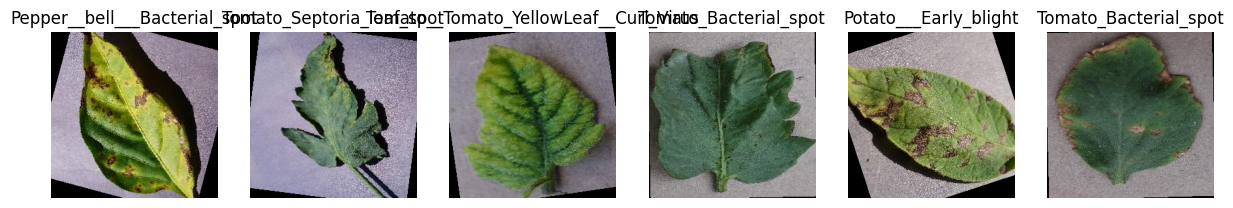

In [ ]:
visualize_images(DataLoader(dataset, batch_size=6, shuffle=True), dataset.classes)

**Splitting the Dataset and Creating DataLoaders for Model Training, Validation, and Testing**

In [ ]:
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

batch_size = 64  # Can be adjusted based on memory capacity

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# Step 8: Print Dataset Summary
print(f"Total Images: {len(dataset)}")
print(f"Training Images: {len(train_dataset)}, Validation Images: {len(val_dataset)}, Test Images: {len(test_dataset)}")
print(f"Number of Classes: {len(dataset.classes)} - {dataset.classes}")

Total Images: 20638
Training Images: 14446, Validation Images: 3095, Test Images: 3097
Number of Classes: 15 - ['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Tomato_Bacterial_spot', 'Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_Leaf_Mold', 'Tomato_Septoria_leaf_spot', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato__Target_Spot', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato__Tomato_mosaic_virus', 'Tomato_healthy']


**Visualizing Sample Images from the Training Dataset**

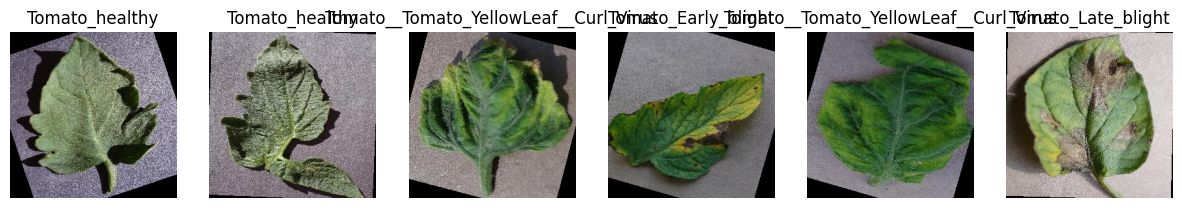

In [ ]:
visualize_images(train_loader, dataset.classes)

###Training Part

**Importing Essential Libraries for Model Training and Optimization**

In [ ]:
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms as transforms
import time

In [ ]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [ ]:
model = models.resnet50(pretrained=True)


num_classes = len(dataset.classes)
model.fc = nn.Linear(model.fc.in_features, num_classes)

model = model.to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 178MB/s]


**Defining Loss Function, Optimizer, and Learning Rate Scheduler**

In [ ]:
criterion = nn.CrossEntropyLoss()  # Loss function for classification
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)  # Reduce LR every 5 epochs

**Setting Up Model Save Path in Google Drive**

In [ ]:
drive_save_path = "/content/drive/MyDrive/Machine_Learning/CV Project V1/PlantDiseaseModels"

os.makedirs(drive_save_path, exist_ok=True)
model_save_file = os.path.join(drive_save_path, "plant_disease_resnet_model_2.pth")

**Training Function for Plant Disease Classification Model**

In [ ]:
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=10):
    start_time = time.time()
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")

        # Training Phase
        model.train()
        running_loss, correct, total = 0.0, 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        train_loss = running_loss / total
        train_acc = 100 * correct / total

        # Validation Phase
        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * images.size(0)
                _, predicted = torch.max(outputs, 1)
                val_correct += (predicted == labels).sum().item()
                val_total += labels.size(0)

        val_loss /= val_total
        val_acc = 100 * val_correct / val_total

        # Print Epoch Results
        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
        print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

        # Save Best Model
        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), model_save_file)
            print("Model Saved!")

        scheduler.step()  # Adjust Learning Rate

    total_time = time.time() - start_time
    print(f"\nTraining Completed in {total_time:.2f} seconds. Best Validation Accuracy: {best_acc:.2f}%")

In [ ]:
num_epochs = 15  # Adjust based on performance

train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=num_epochs)


Epoch 1/15
Train Loss: 0.2860, Train Acc: 92.40%
Val Loss: 0.0645, Val Acc: 98.06%
Model Saved!

Epoch 2/15
Train Loss: 0.0546, Train Acc: 98.31%
Val Loss: 0.0416, Val Acc: 98.84%
Model Saved!

Epoch 3/15
Train Loss: 0.0330, Train Acc: 99.07%
Val Loss: 0.0343, Val Acc: 99.19%
Model Saved!

Epoch 4/15
Train Loss: 0.0318, Train Acc: 99.11%
Val Loss: 0.0242, Val Acc: 99.42%
Model Saved!

Epoch 5/15
Train Loss: 0.0265, Train Acc: 99.18%
Val Loss: 0.0476, Val Acc: 98.35%

Epoch 6/15
Train Loss: 0.0084, Train Acc: 99.83%
Val Loss: 0.0115, Val Acc: 99.77%
Model Saved!

Epoch 7/15
Train Loss: 0.0063, Train Acc: 99.86%
Val Loss: 0.0135, Val Acc: 99.64%

Epoch 8/15
Train Loss: 0.0044, Train Acc: 99.92%
Val Loss: 0.0114, Val Acc: 99.58%

Epoch 9/15
Train Loss: 0.0078, Train Acc: 99.75%
Val Loss: 0.0173, Val Acc: 99.52%

Epoch 10/15
Train Loss: 0.0053, Train Acc: 99.87%
Val Loss: 0.0127, Val Acc: 99.68%

Epoch 11/15
Train Loss: 0.0031, Train Acc: 99.93%
Val Loss: 0.0112, Val Acc: 99.68%

Epoch 12

###Inference

In [ ]:
# Load saved model from Google Drive
model.load_state_dict(torch.load(model_save_file))
model.eval()
print("Model loaded successfully!")

Model loaded successfully!


<ipython-input-18-a8452549f8d4>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_save_file))


**Testing the Trained Model on the Test Dataset**

In [ ]:
def test_model(model, test_loader):

    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    test_acc = 100 * correct / total
    print(f"\nTest Accuracy: {test_acc:.2f}%")

# Run Test Evaluation
test_model(model, test_loader)


Test Accuracy: 99.84%


**Confusion Matrix for Model Performance Analysis**

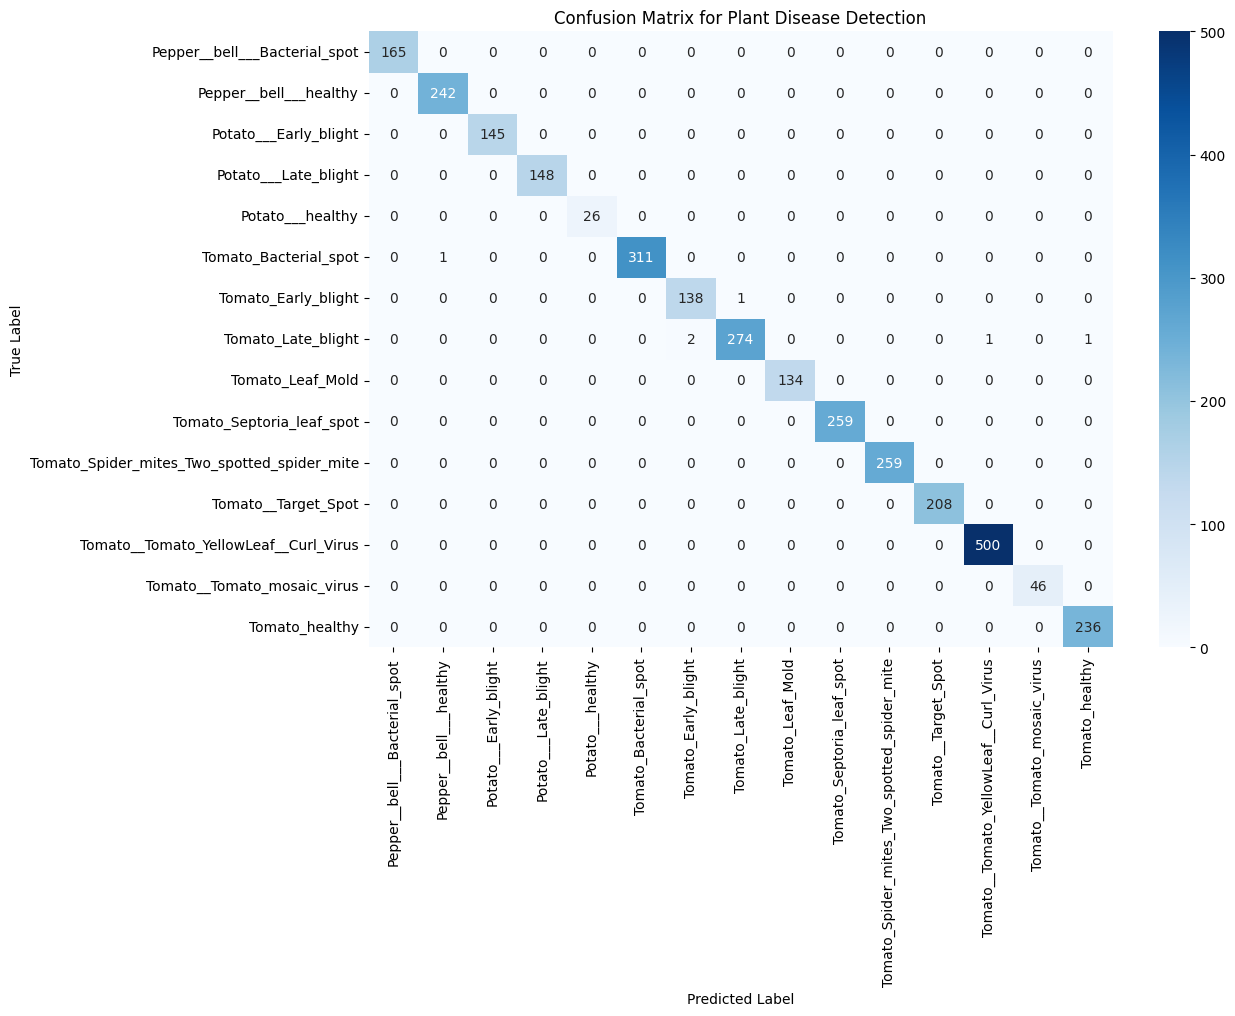

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np

def plot_confusion_matrix(model, test_loader, class_names):
    all_preds, all_labels = [], []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())


    cm = confusion_matrix(all_labels, all_preds)


    plt.figure(figsize=(12, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix for Plant Disease Detection")
    plt.show()

plot_confusion_matrix(model, test_loader, dataset.classes)
